In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
import ast
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\rodge\OneDrive\Desktop\SML\Group Project\comp90051\data\rawData\processedData\decode_sample_result.csv')

In [3]:
ART = df[df['mg_name'] == 'GE_ART'].reset_index(drop=True)
ART.loc[:,'binwave'] = ART['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))

def statistical_ART(signal): 
    return {
        'mean'  :np.mean(signal),
        'std'   :np.std(signal),
        'max'   :np.max(signal),
        'min'   :np.min(signal),
        'range' :np.ptp(signal),
        'skewness':skew(signal),
        'kurtosis':kurtosis(signal),
        'variance':np.var(signal)
    }

ART_matrix = np.array([list(statistical_ART(row).values()) for row in ART['binwave']])
U, S, Vt = np.linalg.svd(ART_matrix, full_matrices=False)
print('Singular Values:', S)


Singular Values: [2.72547916e+06 6.51869409e+03 5.93300480e+02 2.68054609e+02
 5.76830155e+01 7.90109815e+00 4.49263652e-01 5.73106049e-12]


In [4]:
ART_matrix

array([[ 1.76458333e+01,  2.11639234e+02,  2.33000000e+02, ...,
         6.03062819e-05, -1.99982940e+00,  4.47911652e+04],
       [ 1.93500000e+01,  2.16276990e+02,  2.39000000e+02, ...,
         1.00350750e-04, -1.99972149e+00,  4.67757365e+04],
       [ 2.03402778e+01,  2.19155433e+02,  2.42250000e+02, ...,
         1.07922581e-05, -1.99985240e+00,  4.80291040e+04],
       ...,
       [ 1.95430556e+01,  2.01153244e+02,  2.25000000e+02, ...,
         8.37172873e-05, -1.99948391e+00,  4.04626277e+04],
       [ 1.87833333e+01,  1.94092018e+02,  2.17500000e+02, ...,
         1.40790489e-05, -1.99952798e+00,  3.76717114e+04],
       [ 1.76263889e+01,  1.88610823e+02,  2.10250000e+02, ...,
         6.85134368e-05, -1.99971729e+00,  3.55740427e+04]])

In [5]:
ECG = df[df['mg_name'] == 'GE_ECG'].reset_index(drop=True)
ECG.loc[:,'binwave'] = ECG['binwave'].apply(lambda x: np.array(ast.literal_eval(x)))

# Extract features from ECG signal using FFT
def featureExtraction_fft(signal, rate_hz):
    
    fft_transfer = fft(signal)
    magnitude = np.abs(fft_transfer)
    phase = np.angle(fft_transfer)

    freq_resolution = rate_hz / len(signal)

    low_freq_range = (0.5, 10)
    qrs_freq_range = (10, 50)
    high_freq_range = (50, rate_hz/2)

    low_freq_indices = np.floor(np.array(low_freq_range) / freq_resolution).astype(int)
    qrs_freq_indices = np.floor(np.array(qrs_freq_range) / freq_resolution).astype(int)
    high_freq_indices = np.floor(np.array(high_freq_range) / freq_resolution).astype(int)

    low_freq_power = np.sum(magnitude[low_freq_indices[0]:low_freq_indices[1]])
    qrs_freq_power = np.sum(magnitude[qrs_freq_indices[0]:qrs_freq_indices[1]])
    high_freq_power = np.sum(magnitude[high_freq_indices[0]:high_freq_indices[1]])
    peak_freq = np.argmax(magnitude[1:]) * freq_resolution  # Frequency with highest magnitude

    peaks, _ = find_peaks(magnitude)
    num_peaks = len(peaks)
    rate_hz = rate_hz

    return {
        'low_freq_power': low_freq_power,
        'qrs_freq_power': qrs_freq_power,
        'high_freq_power': high_freq_power,
        'peak_freq': peak_freq,
        'num_peaks': num_peaks,
        'mean_magnitude': np.mean(magnitude),
        'std_magnitude': np.std(magnitude),
        'mean_phase': np.mean(phase),
        'std_phase': np.std(phase),
        'skewness_magnitude': skew(magnitude),
        'kurtosis_magnitude': kurtosis(magnitude),
        'rate_hz':  rate_hz
    }


feature_names = ['low_freq_power', 'qrs_freq_power', 'high_freq_power', 'peak_freq', 'num_peaks', 
                 'mean_magnitude', 'std_magnitude', 'mean_phase', 'std_phase', 
                 'skewness_magnitude', 'kurtosis_magnitude','rate_hz']

fft_result = []

#extract features from each ECG signal
for i in range(len(ECG)):
    signal = ECG['binwave'][i]
    rate_hz = ECG['hz'][i]
    feature_result = featureExtraction_fft(signal, rate_hz)
    fft_result.append([feature_result[name] for name in feature_names])

#transform the result into a dataframe for visualization
ECG_df = pd.DataFrame(fft_result, columns=feature_names)

#drop the rate_hz column
ECG_matrix = np.array(fft_result)[:,:-1]

#tranform the matrix into a singular value decomposition for model training
U, S, Vt = np.linalg.svd(ECG_matrix, full_matrices=False)
print('Singular Values:', S)




Singular Values: [1.58660426e+06 7.34820121e+05 1.36456329e+05 2.34538036e+04
 1.35926601e+03 7.41792669e+02 2.17705371e+02 1.36434765e+02
 1.57793027e+01 1.39031110e+00 2.97851762e-01]


In [6]:
ECG_df

,low_freq_power,qrs_freq_power,high_freq_power,peak_freq,num_peaks,mean_magnitude,std_magnitude,mean_phase,std_phase,skewness_magnitude,kurtosis_magnitude,rate_hz
0,18353.003921,1444.235029,2666.155616,89.0,51,1490.104384,17945.198854,1.578984e-16,1.768109,13.202275,173.120279,180
1,17099.482179,2116.864827,8387.297133,89.0,53,1598.140490,18495.753242,-1.578984e-16,2.126970,13.222004,173.494848,180
2,15773.698119,2023.555139,5698.485964,89.0,57,1617.019325,19283.893500,0.000000e+00,1.979967,13.238219,173.795922,180
3,15035.273418,2001.599423,2254.109333,89.0,53,1601.799802,19584.777492,0.000000e+00,1.699912,13.253166,174.072710,180
4,12205.897503,1606.908597,1632.666094,89.0,67,1574.338580,19620.445740,-9.868649e-18,1.741192,13.268366,174.353106,180
...,...,...,...,...,...,...,...,...,...,...,...,...
1197,22565.214587,1653.808815,4759.991112,89.0,57,1520.422383,17722.664974,-1.745329e-02,1.992344,13.144805,172.026898,180
1198,22563.882813,1568.056282,4054.708393,89.0,51,1477.618305,17282.739689,-1.745329e-02,2.005289,13.134560,171.830016,180
1199,21745.248765,1837.940902,4445.368828,89.0,61,1449.428428,16849.817335,-1.745329e-02,2.028382,13.141350,171.960566,180
1200,20849.134301,1474.980332,3530.471360,89.0,63,1404.250955,16501.815938,-1.745329e-02,2.041231,13.147985,172.087133,180


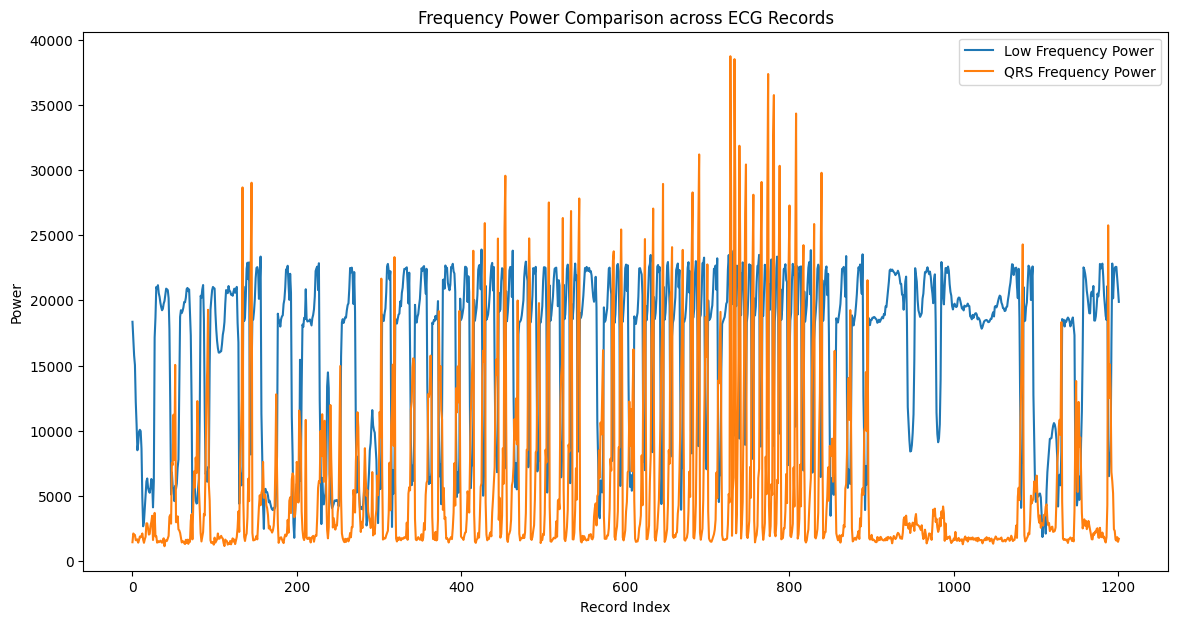

In [7]:
# Plot the frequency power comparison across ECG records

plt.figure(figsize=(14, 7))
plt.plot(ECG_df['low_freq_power'], label='Low Frequency Power')
plt.plot(ECG_df['qrs_freq_power'], label='QRS Frequency Power')
# plt.plot(ECG_df['high_freq_power'], label='High Frequency Power')
plt.title('Frequency Power Comparison across ECG Records')
plt.xlabel('Record Index')
plt.ylabel('Power')
plt.legend()
plt.show()


In [17]:
df = ECG['binwave']
df

0       [1439.0, -1229.0, 1436.0, -1229.0, 1432.0, -12...
1       [1442.0, -1256.0, 1446.0, -1258.0, 1448.0, -12...
2       [1503.0, -1331.0, 1505.0, -1336.0, 1502.0, -13...
3       [1539.0, -1381.0, 1539.0, -1376.0, 1539.0, -13...
4       [1528.0, -1399.0, 1535.0, -1406.0, 1531.0, -13...
                              ...                        
1197    [-1213.0, 1462.0, -1211.0, 1458.0, -1211.0, 14...
1198    [-1178.0, 1421.0, -1181.0, 1418.0, -1182.0, 14...
1199    [-1153.0, 1392.0, -1151.0, 1390.0, -1156.0, 13...
1200    [-1127.0, 1351.0, -1124.0, 1351.0, -1133.0, 13...
1201    [-1108.0, 1324.0, -1110.0, 1332.0, -1106.0, 13...
Name: binwave, Length: 1202, dtype: object

In [25]:
import numpy as np
import pywt
import pandas as pd

def wavelet_denoising(signal, wavelet='db4', level=5):
    # 确保信号是数值类型
    signal = np.array(signal).astype(float)
    
    # 检查信号是否全为0
    if np.all(signal == 0):
        return signal  # 如果信号全为0，直接返回
    
    # 1. 进行小波分解
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # 2. 计算阈值（使用更保守的阈值）
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal))) * 0.5  # 减小阈值
    
    # 3. 对系数进行阈值处理
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    
    # 4. 重构信号
    denoised_signal = pywt.waverec(coeffs_thresholded, wavelet)
    
    # 确保重构信号的长度与原始信号相同
    denoised_signal = denoised_signal[:len(signal)]
    
    return denoised_signal

# 对DataFrame中的每一行应用小波去噪
def denoise_dataframe(df):
    return df.apply(lambda row: wavelet_denoising(row))

# 应用去噪函数到整个DataFrame
denoised_df = denoise_dataframe(df)

# 打印原始数据和去噪后的数据进行比较
print("Original data (first row):")
print(df.iloc[0])
print("\nDenoised data (first row):")
print(denoised_df.iloc[0])



Original data (first row):
[ 1439. -1229.  1436. -1229.  1432. -1232.  1435. -1231.  1435. -1223.
  1433. -1227.  1439. -1232.  1436. -1236.  1435. -1231.  1434. -1237.
  1441. -1232.  1436. -1234.  1434. -1232.  1435. -1234.  1433. -1236.
  1435. -1236.  1433. -1236.  1436. -1240.  1432. -1238.  1438. -1238.
  1435. -1236.  1427. -1236.  1433. -1236.  1433. -1238.  1431. -1234.
  1429. -1236.  1432. -1237.  1434. -1236.  1431. -1234.  1433. -1235.
  1431. -1239.  1432. -1241.  1446. -1235.  1439. -1238.  1439. -1238.
  1439. -1234.  1434. -1240.  1433. -1236.  1435. -1238.  1436. -1241.
  1437. -1238.  1440. -1241.  1435. -1244.  1434. -1239.  1431. -1232.
  1431. -1239.  1435. -1242.  1439. -1242.  1437. -1240.  1436. -1237.
  1438. -1234.  1432. -1242.  1436. -1240.  1435. -1241.  1433. -1246.
  1439. -1242.  1440. -1243.  1442. -1237.  1443. -1244.  1437. -1246.
  1433. -1238.  1437. -1245.  1439. -1249.  1435. -1242.  1439. -1237.
  1434. -1240.  1434. -1239.  1436. -1245.  1438. 

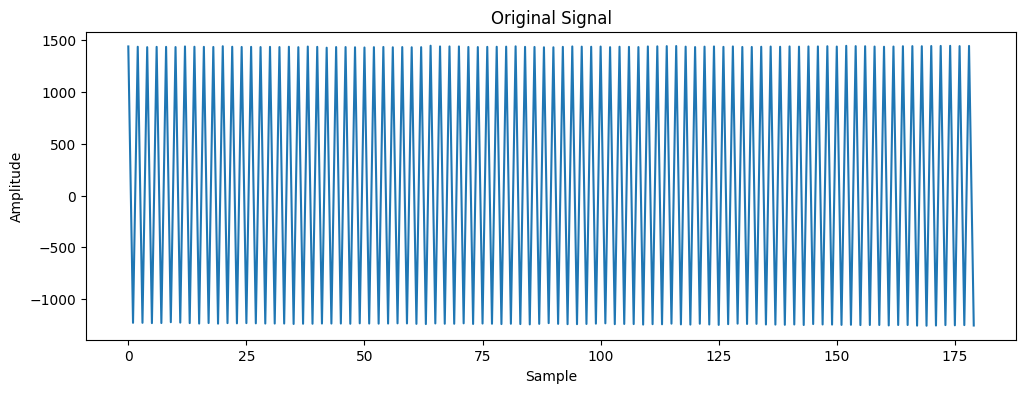

C:\Users\rodge\AppData\Roaming\Python\Python312\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 180, using nperseg = 180
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


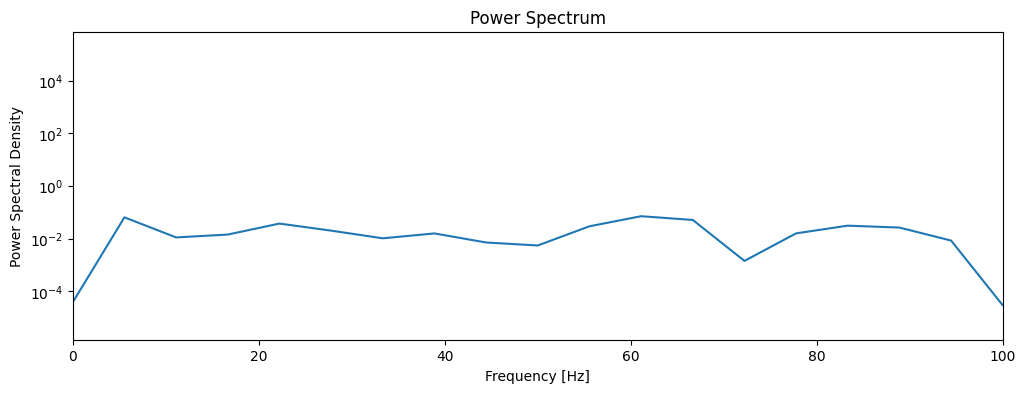

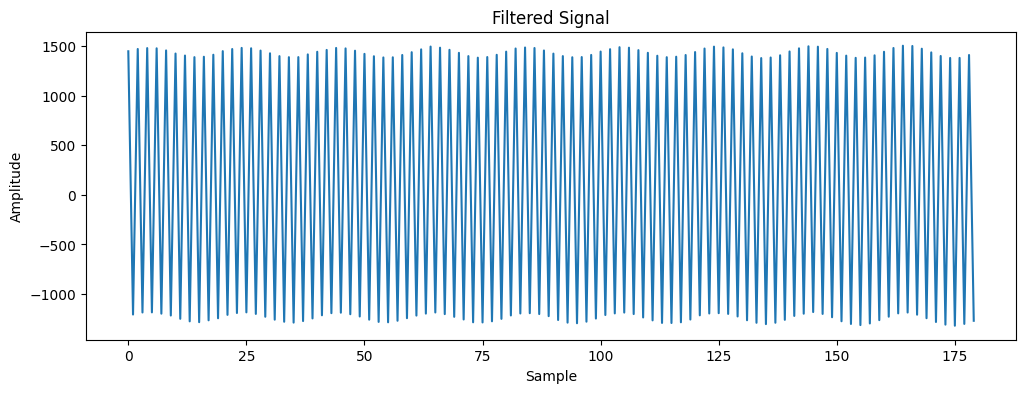

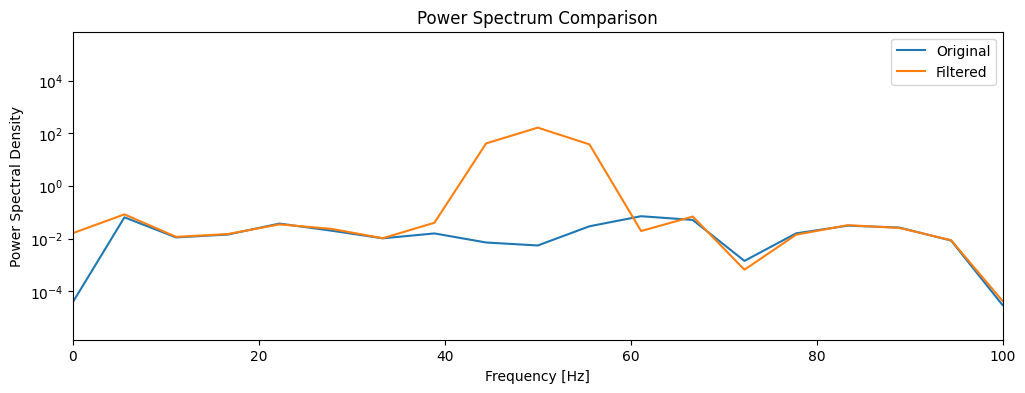

Original data mean: 98.05
Filtered data mean: 97.70519320105281
Original data std: 1338.5732216514052
Filtered data std: 1339.138391210003


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, iirnotch, filtfilt
from scipy.fft import fft, fftfreq

# 您提供的数据
data = [1439, -1229, 1436, -1229, 1432, -1232, 1435, -1231, 1435, -1223, 1433, -1227, 1439, -1232, 1436, -1236, 1435, -1231, 1434, -1237, 1441, -1232, 1436, -1234, 1434, -1232, 1435, -1234, 1433, -1236, 1435, -1236, 1433, -1236, 1436, -1240, 1432, -1238, 1438, -1238, 1435, -1236, 1427, -1236, 1433, -1236, 1433, -1238, 1431, -1234, 1429, -1236, 1432, -1237, 1434, -1236, 1431, -1234, 1433, -1235, 1431, -1239, 1432, -1241, 1446, -1235, 1439, -1238, 1439, -1238, 1439, -1234, 1434, -1240, 1433, -1236, 1435, -1238, 1436, -1241, 1437, -1238, 1440, -1241, 1435, -1244, 1434, -1239, 1431, -1232, 1431, -1239, 1435, -1242, 1439, -1242, 1437, -1240, 1436, -1237, 1438, -1234, 1432, -1242, 1436, -1240, 1435, -1241, 1433, -1246, 1439, -1242, 1440, -1243, 1442, -1237, 1443, -1244, 1437, -1246, 1433, -1238, 1437, -1245, 1439, -1249, 1435, -1242, 1439, -1237, 1434, -1240, 1434, -1239, 1436, -1245, 1438, -1246, 1436, -1248, 1439, -1245, 1437, -1250, 1439, -1241, 1439, -1245, 1441, -1246, 1438, -1249, 1445, -1248, 1442, -1251, 1441, -1250, 1438, -1250, 1436, -1254, 1438, -1250, 1441, -1250, 1442, -1256, 1441, -1257, 1443, -1255, 1444, -1251, 1445, -1253, 1442, -1251, 1444, -1255]

# 假设采样率为1000Hz（需要根据实际情况调整）
fs = 1000

# 绘制原始信号
plt.figure(figsize=(12, 4))
plt.plot(data)
plt.title('Original Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# 频谱分析
f, Pxx = welch(data, fs, nperseg=1024)
plt.figure(figsize=(12, 4))
plt.semilogy(f, Pxx)
plt.title('Power Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim(0, 100)  # 只显示0-100Hz的频谱
plt.show()

# 应用50Hz陷波滤波器
f0 = 50.0  # 陷波频率
Q = 30.0  # 品质因数
b, a = iirnotch(f0, Q, fs)
filtered_data = filtfilt(b, a, data)

# 绘制滤波后的信号
plt.figure(figsize=(12, 4))
plt.plot(filtered_data)
plt.title('Filtered Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# 比较滤波前后的频谱
f_filtered, Pxx_filtered = welch(filtered_data, fs, nperseg=1024)
plt.figure(figsize=(12, 4))
plt.semilogy(f, Pxx, label='Original')
plt.semilogy(f_filtered, Pxx_filtered, label='Filtered')
plt.title('Power Spectrum Comparison')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim(0, 100)
plt.legend()
plt.show()

print("Original data mean:", np.mean(data))
print("Filtered data mean:", np.mean(filtered_data))
print("Original data std:", np.std(data))
print("Filtered data std:", np.std(filtered_data))